## Task 1
`predictive_maintenance_dataset.csv` is a file that contains parameters and settings (`operational_setting_1`, `operational_setting_2`, `sensor_measurement_1`, `sensor_measurement_2`, etc.) for many wind turbines. There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. Your task is to create a model that, when fed with operational settings and sensor measurements (`unit_number` and `time_stamp` will *not* be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

In [4]:
# Evaluation metrics
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score


In [5]:
# Classification models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
# Libraries for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

In [7]:
# Libraries for feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [63]:
# To save the final model
import pickle

In [8]:
clf_data = pd.read_csv("predictive_maintenance_dataset.csv")

In [9]:
clf_data.shape

(144203, 27)

In [10]:
clf_data.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,133.75,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,522.19,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,163.11,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,130.58,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,519.44,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682


In [11]:
clf_data['operational_setting_3'].head()

0    High
1    High
2     Low
3    High
4    High
Name: operational_setting_3, dtype: object

In [12]:
clf_data['operational_setting_3'].map( {'High':1, 'Low':0} ).head()

0    1.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: operational_setting_3, dtype: float64

In [13]:
clf_data['operational_setting_3'].map( {'High':1, 'Low':0} ).unique()

array([  1.,   0.,  nan])

In [14]:
clf_data['os3_binary'] = clf_data['operational_setting_3'].map( {'High':1, 'Low':0} )

In [15]:
clf_data.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,os3_binary
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717,1.0
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958,1.0
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202,0.0
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614,1.0
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682,1.0


In [25]:
X = clf_data.drop(['time_stamp', 'unit_number','status', 'operational_setting_3'], axis=1)

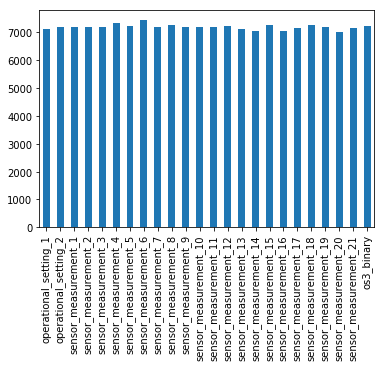

In [26]:
X.isnull().sum().plot(kind='bar')

In [27]:
# Imputing missing values in categorical variables
data_imputer = Imputer(strategy='most_frequent')
X['os3_binary'] = data_imputer.fit_transform(X['os3_binary'].reshape(-1,1))

/Users/avinash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [28]:
# Checking the unique values for os3
X['os3_binary'].unique()

array([ 1.,  0.])

In [30]:
data_imputer = Imputer()
X_imp = data_imputer.fit_transform(X)

In [31]:
X_imp = pd.DataFrame(X_imp, columns=X.columns)

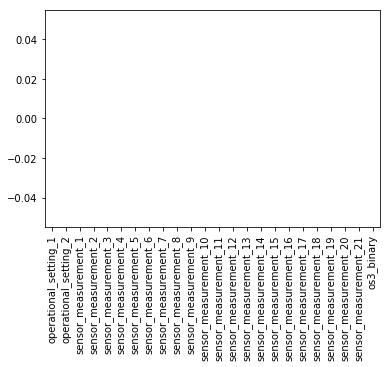

In [32]:
X_imp.isnull().sum().plot(kind='bar')

In [33]:
y = clf_data['status']

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.15, random_state=7)

In [35]:
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

In [60]:
def evaluate(model):
    print("-----Training-----", "\n")
    # Accuracy
    train_score = model.score(X_train, y_train)
    print("Train Accuracy: ", train_score)
    # Recall Score
    train_recall = recall_score(y_pred = model.predict(X_train), y_true=y_train)
    print("Train Recall: ", train_recall)
    # Confusion Matrix
    print("Train Confusion Matrix")
    cm_train = pd.DataFrame(confusion_matrix(y_pred = model.predict(X_train), y_true=y_train))
    print(cm_train, "\n")
    
    print("-----Validation-----", "\n")
    # Accuracy
    val_score = model.score(X_val, y_val)
    print("Test Accuracy: ", val_score)
    # Recall Scores
    val_recall = recall_score(y_pred = model.predict(X_val), y_true=y_val)
    print("Test Recall: ", val_recall)
    # Confusion Matrix
    print("Test Confusion Matrix")
    cm_val = pd.DataFrame(confusion_matrix(y_pred = model.predict(X_val), y_true=y_val))
    print(cm_val)

def evaluate_test(model):
    print("-----Testing-----", "\n")
    # Accuracy
    test_score = model.score(X_test, y_test)
    print("Train Accuracy: ", test_score)
    # Recall Score
    test_recall = recall_score(y_pred = model.predict(X_test), y_true=y_test)
    print("Test Recall: ", test_recall)
    # Confusion Matrix
    print("Test Confusion Matrix")
    cm_test = pd.DataFrame(confusion_matrix(y_pred = model.predict(X_test), y_true=y_test))
    print(cm_test, "\n")

## Using Logistic Regression

In [37]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
evaluate(lr_clf)

-----Training----- 

Train Accuracy:  0.995786382047
Train Recall:  0.0
Train Confusion Matrix
        0  1
0  103747  0
1     439  0 

-----Validation----- 

Test Accuracy:  0.995812030893
Test Recall:  0.0
Test Confusion Matrix
       0  1
0  18309  1
1     76  0


## Using SGD

In [39]:
sgd_clf = SGDClassifier(penalty="l1")
sgd_clf.fit(X_train, y_train)

/Users/avinash/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [40]:
evaluate(sgd_clf)

-----Training----- 

Train Accuracy:  0.995786382047
Train Recall:  0.0
Train Confusion Matrix
        0  1
0  103747  0
1     439  0 

-----Validation----- 

Test Accuracy:  0.995866420102
Test Recall:  0.0
Test Confusion Matrix
       0  1
0  18310  0
1     76  0


## Using Random Forest

In [41]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
evaluate(rf_clf)

-----Training----- 

Train Accuracy:  0.999433705104
Train Recall:  0.865603644647
Train Confusion Matrix
        0    1
0  103747    0
1      59  380 

-----Validation----- 

Test Accuracy:  0.996355922985
Test Recall:  0.144736842105
Test Confusion Matrix
       0   1
0  18308   2
1     65  11


## XGBoost

In [43]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
evaluate(xgb)

-----Training----- 

Train Accuracy:  0.996515846659
Train Recall:  0.198177676538
Train Confusion Matrix
        0   1
0  103736  11
1     352  87 

-----Validation----- 

Test Accuracy:  0.996138366148
Test Recall:  0.118421052632
Test Confusion Matrix
       0  1
0  18306  4
1     67  9


# GradientBoostingClassifier

In [45]:
gbc_clf = GradientBoostingClassifier()
gbc_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [46]:
evaluate(gbc_clf)

-----Training----- 

Train Accuracy:  0.997254909489
Train Recall:  0.425968109339
Train Confusion Matrix
        0    1
0  103713   34
1     252  187 

-----Validation----- 

Test Accuracy:  0.995812030893
Test Recall:  0.25
Test Confusion Matrix
       0   1
0  18290  20
1     57  19


## Hyper Parameter Optimization for GradientBoostingClassifier

In [48]:
parameters = {'learning_rate' : np.logspace(-2,0,num=3),
              'n_estimators': [100, 200, 250], 
              'max_depth':[3,5,7], 
              'max_features': ['auto', 'sqrt']}

In [49]:
gbc = GradientBoostingClassifier()
opt_gbc = RandomizedSearchCV(gbc, parameters, n_jobs = 3, scoring= 'recall', n_iter=9)
opt_gbc.fit(X_train,y_train)
print(opt_gbc.best_params_)
print("Accuracy:", opt_gbc.best_score_)
print("Error:", 1- opt_gbc.best_score_)

{'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.10000000000000001}
Accuracy: 0.236914749338
Error: 0.763085250662


In [50]:
gbc_clf = GradientBoostingClassifier(n_estimators = 250, max_depth = 5, learning_rate = 0.1)
gbc_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [51]:
evaluate(gbc_clf)

-----Training----- 

Train Accuracy:  0.999750446317
Train Recall:  0.945330296128
Train Confusion Matrix
        0    1
0  103745    2
1      24  415 

-----Validation----- 

Test Accuracy:  0.995050581965
Test Recall:  0.315789473684
Test Confusion Matrix
       0   1
0  18271  39
1     52  24


## Feature Selection 

#### Using Extra trees classifier and L1 for feature selection

In [52]:
clf_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=250, random_state=7))),
  ('classification', GradientBoostingClassifier(n_estimators = 250, max_depth = 5, learning_rate = 0.1))
])
clf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_sam...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [53]:
evaluate(clf_pipeline)

-----Training----- 

Train Accuracy:  0.999779240973
Train Recall:  0.952164009112
Train Confusion Matrix
        0    1
0  103745    2
1      21  418 

-----Validation----- 

Test Accuracy:  0.995594474056
Test Recall:  0.302631578947
Test Confusion Matrix
       0   1
0  18282  28
1     53  23


#### Using LinearSVC and L1 for feature selection

In [56]:
svc_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual = False))),
  ('classification', GradientBoostingClassifier(n_estimators = 250, max_depth = 5, learning_rate = 0.1))
])
svc_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        norm_order=1, prefit...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [57]:
evaluate(svc_pipeline)

-----Training----- 

Train Accuracy:  0.999068972799
Train Recall:  0.799544419134
Train Confusion Matrix
        0    1
0  103738    9
1      88  351 

-----Validation----- 

Test Accuracy:  0.995594474056
Test Recall:  0.315789473684
Test Confusion Matrix
       0   1
0  18281  29
1     52  24


#### Using Logistic Regression and L1 for feature selection

In [58]:
lr_pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1"))),
  ('classification', GradientBoostingClassifier(n_estimators = 250, max_depth = 5, learning_rate = 0.1))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [59]:
evaluate(lr_pipeline)

-----Training----- 

Train Accuracy:  0.994500220759
Train Recall:  0.95444191344
Train Confusion Matrix
        0    1
0  103194  553
1      20  419 

-----Validation----- 

Test Accuracy:  0.991025780485
Test Recall:  0.302631578947
Test Confusion Matrix
       0    1
0  18198  112
1     53   23


# Test scores for the final model

In [61]:
evaluate_test(svc_pipeline)

-----Testing----- 

Train Accuracy:  0.994868475799
Test Recall:  0.279661016949
Test Confusion Matrix
       0   1
0  21487  26
1     85  33 



In [67]:
roc_auc_score(y_score=svc_pipeline.predict(X_train), y_true=y_train)

0.89972883481901256

## Saving final model

In [64]:
save_classifier = open("task1_model.pickle", "wb")
pickle.dump(svc_pipeline, save_classifier)
save_classifier.close()